# 智能医疗项目案例：DICOM 医学数字影像预处理

<img src="./img/dicom3d.png" width="60%">

**DICOM** (DigitalImaging and Communications in Medicine) 是指医疗数字影像传输协定，是用于医学影像处理、储存、打印、传输的一组通用的标准协定。它包含了文件格式的定义以及网络通信协议。DICOM 是以 TCP/IP 为基础的应用协定，并以 TCP/IP 联系各个系统。两个能接受 DICOM 格式的医疗仪器间，可通过 DICOM 格式的文件，来接收与交换影像及病人资料。

<img src="./img/dicom_gateway_workflow.png" width="50%">

目前，DICOM 被广泛应用于放射医疗，心血管成像以及放射诊疗诊断设备（X 射线，CT，核磁共振，超声等），并且在眼科和牙科等其它医学领域得到越来越深入广泛的应用。目前采用的标准是 DICOM 3.0，每一张图像中都携带着大量的信息，这些信息具体可以分为以下四类：

- Patient
- Study
- Series
- Image

## 案例介绍

原发性支气管癌（Primary Bronchogenic Carcinoma），简称肺癌（Lung Cancer），为起源于支气管黏膜或腺体的恶性肿瘤。利用由美国国家癌症研究所提供的数千张高分辨率肺部扫描图的数据集，科研人员将可开发出能够准确判断肺部病变何时为癌变病变的算法。这将极大地降低困扰当前检测技术的假阳性率，让患者更早地获得拯救生命的干预措施，并给放射科医生更多的时间与患者相处。

### 案例目标与操作步骤

在深度学习的过程中，使用 DICOM 文件进行深度学习训练可能是一个挑战，特别是考虑到它们的异构性质。在它们被 CNN 使用之前，需要进行一些必要的数据预处理工作。本案例旨在提供一个全面的概述有用的步骤，在将数据输入卷积神经网络或者其它机器学习模型之前执行数据预处理工作。具体步骤包括 —— 
- **Pydicom 基本操作**：抽取一位患者的其中一张 CT 扫描影像，了解 DICOM 格式文件内包含的信息并熟悉 Pydicom 的基本操作
- **加载 DICOM 影像**：添加缺失的元数据
- **HU 单位转换**：将像素值转换为亨斯菲尔德单位 **(HU)**，以及这些单位值对应的组织
- **CT 重采样**：重采样到一个同构分辨率，以消除扫描仪分辨率的方差
- **渲染三维扫描影像**：3D 渲染绘图，可视化是非常有用的
- **肺部切割**：分割肺部组织，以便仅将关键的信息输入神经网络
- **归一化**：执行数据标准化操作
- **数值中心化**：执行数据标准化操作，引用 LUNA 16 竞赛经验均值实现均值预处理

本案例适合作为大数据、人工智能、生物医学工程专业 —— Python 数据预处理实践课程的配套教学案例。

### 案例数据集

本案例数据集来自 2017 年数据科学碗比赛。在这个数据集中，有超过 `1000` 张来自高危患者的 DICOM 格式 CT 图像。每个图像包含一系列的胸部轴向切片。每个图像都有不同数量的 2D 切片，这些切片可以根据扫描的机器和病人的不同而变化。DICOM 文件有一个头文件，其中包含有关患者 `id` 的必要信息。竞赛的任务是创建一种自动化的方法，能够在扫描后的一年内确定患者是否会被诊断为肺癌。真实标签经病理诊断证实。本数据集中的图像来自许多来源，且质量各不相同。例如：以前的扫描是用不那么精密的设备成像的。总的来说，阶段二的数据应该比阶段一的数据更新、质量更高(通常具有更薄的切片厚度)。理想情况下，你的算法应该在一个图像质量范围内表现良好。由于完整的数据集非常庞大，超过 **160 GB**，在本案例实验环节，仅抽取其中一名病患的 DICOM 图像进行处理。

<img src="./img/0_lNvuz048R32LsTlc.gif" width="30%">

## 1. Pydicom 基本操作

DICOM（医学数字成像）是医学图像数据集、存储和传输的基础。在开始实验前，首先需要确保安装了 Pydicom 库，它支持 DICOM 格式的读取：可以将 dicom 文件读入 Python 结构，同时支持修改后的数据集可以再次写入 DICOM格 式文件。但需要注意，它不是被设计为查看图像，主要是用来操作 DICOM 文件的各种数据元素。关于 Pydicom 的详细说明，请查阅官方 [技术文档](https://pydicom.github.io/pydicom/stable/)。

### 1.1 Pydicom 库

首先，请确保实验环境中已安装了 Pydicom 医学数字影像处理库，可以通过在终端执行 ——

```bash
pip install pydicom==2.3.0
```
**如果在本地实验环境中没有安装 Pydicom 库，请移除下方代码注释符 `#`，执行 Bash 命令完成安装**。

In [1]:
# !pip install pydicom==2.3.0

在本实验中，我们采用 Pydicom 2.3.0 版本。

In [2]:
!pip list | grep pydicom

pydicom                           2.3.0
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


### 1.2 加载依赖库

In [3]:
# 加载基础数据科学库
import numpy as np # 线性代数计算库
import pandas as pd # 数据处理库，如读取 csv 文件
import matplotlib.pyplot as plt # 数据可视化库
# 魔法命令，使 matplotlib 图像直接输出至 Jupyter Notebook 中显示
%matplotlib inline

plt.rcParams['font.family'] = 'sans-serif'    # 用来正常显示中文
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False   # 设置正常显示符号

# 加载 pydicom
import pydicom

# 多维图像处理
import scipy.ndimage

# 机器学习图像库
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# 基本参数定义
import os # 系统交互库
dicom_folder = './data/' # 数据集存储路径
PathDicom = './data/sample_images'     # 批量读取单一病例目录
patients = os.listdir(dicom_folder)    # 列出数据集目录下子目录
patients.sort()                        # 列出数据集目录

### 1.3 数据探索

我们抽取实验中患者的其中一张 DICOM 扫描影像样本进行了解 ——

In [4]:
# DICOM 文件路径
ds = pydicom.read_file(dicom_folder + '/sample_images/0acb5ac56995154ffe0344fe319c876b.dcm')

每一个 DICOM 标签都是由两个十六进制数的组合来确定的，分别为 `Group` 和 `Element`。如 `(0010,0010)` 这个标签表示的是 `Patient's Name`，它存储着这张 DICOM 图像的患者姓名。`pydicom.read_file` 函数已经为我们完成了解析，输出所有 DICOM 元数据标签名称。

In [5]:
print(ds.dir()) 

['AcquisitionNumber', 'BitsAllocated', 'BitsStored', 'BurnedInAnnotation', 'Columns', 'FrameOfReferenceUID', 'HighBit', 'ImageOrientationPatient', 'ImagePositionPatient', 'InstanceNumber', 'KVP', 'LongitudinalTemporalInformationModified', 'Modality', 'PatientBirthDate', 'PatientID', 'PatientName', 'PhotometricInterpretation', 'PixelData', 'PixelPaddingValue', 'PixelRepresentation', 'PixelSpacing', 'PositionReferenceIndicator', 'RescaleIntercept', 'RescaleSlope', 'Rows', 'SOPClassUID', 'SOPInstanceUID', 'SamplesPerPixel', 'SeriesDescription', 'SeriesInstanceUID', 'SeriesNumber', 'SliceLocation', 'SpecificCharacterSet', 'StudyInstanceUID', 'WindowCenter', 'WindowWidth']


输出包含 `Patient` 的 DICOM 元数据标签，提取患者信息。

In [6]:
print(ds.dir('Patient')) 

['ImageOrientationPatient', 'ImagePositionPatient', 'PatientBirthDate', 'PatientID', 'PatientName']


输出 DICOM 元数据标签相应的属性值。

In [7]:
print(ds.ImageOrientationPatient, 
      ds.ImagePositionPatient, 
      ds.PatientBirthDate, 
      ds.PatientID, 
      ds.PatientName ) 

[1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000] [-118.900002, -145.000000, -75.980003] 19000101 fe5c37e82b412833b8ad0abb57978377 fe5c37e82b412833b8ad0abb57978377


输出完整的数据元素，包括 DICOM 标签编码值（Group, Element）, VR, Value。其中，VR 是 DICOM 标准中用来描述数据类型的，总共有 27 个值。详细说明可查阅 DICOM 中文协议文档。

| VR                                    | 含义                                                                                                                                                 | 允许 字符                                     | 数据长度             |
| :------------------------------------- | :--------------------------------------------------------------------------------------------------------------------------------------- | :----------------------------------------- | :--------------------------- |
| cs - Code String <br/>代码字符串                | 开头结尾可以有没有意义的空格的字符串，<br/>比如："CD123\_4"                                                                                                                   | 大写字母， 0-9，空格 以及下划线字符                      | 最多16个字符          |
| sH - Short Sring <br/>短字符串                 | 短字符串，比如：电话号码，ID等                                                                                                                                   |                                           | 最多16个字符          |
| LO - Long String <br/>长字符串                 | 一个字符串，可能在开头、结尾填有空格。<br/>比如："Introduction to DICOM"                                                                                                      |                                           | 最多64个字符          |
| ST -Short Text <br/>短文本                    | 可能包含一个或多个段落的字符串                                                                                                                                    |                                           | 最多1024个字符        |
| LT - Long Text <br/>短文本                    | 可能包含一个或多个锻炼的字符串，与LO相同，但可以更长                                                                                                                        |                                           | 最多10240个字符       |
| UT - Unlimited Text <br/>无限制文本             | 包含一个或多个段落的字符串，与 LT 类似                                                                                                                              |                                           | 最多(2的32次方-2) 个字符 |
| AE - Application Entity <br/>应用实体          | 标识一个设备的名称的字符串，开头和结尾可以有无意义的字符。<br/>比如："MyPC01"                                                                                                           |                                           | 最多16个字符          |
| PN - Person Name <br/>病人姓名                 | 有插入符号 (^) 作为姓名分隔符的病人姓名。<br/>比如："SMITH^JOHN"，"Morrison- Jones^Susan^^^Ph.D， Chief Executive Officer"                                                     |                                           | 最多64个字符          |
| UI - Unique Identifier (UID) <br/>唯一标识符    | 一个用作唯一标识各类项目的包含 UID 的字符串。<br/>比如："1.2.840.10008.1.1"                                                                                                    | 0-9 和半角句号 (.)                             | 最多64个字符          |
| DA - Date <br/>日期                          | 格式为 YYYMMDD 的字符串；YYYYY 代表年；MM代表月；DD 代表日。<br/>比如："20050822" 表示 2005 年 8 月 22 日                                                                           | 0-9                                       | 8个字符             |
| TM - Time <br/>时间                          | 格式为 HHMMSS 的字符串。FRAC；HH 表示小时 (范围 "0"-"23")；MM 表示分钟 (范围 "00"-"59")；<br/>而 FRAC 包含秒的小数部分，即：百万分之一秒。比如 "183200.00" 表示下午 6:32                                | 0-9 和半角句号 (.)                             | 最多16个字符          |
| DT- Date Time <br/>日期时间                    | 格式为 YYYMDDHHMMSS. FFFF，串联的日期时间字符串。<br/>字符串的各部分从左至右是：年 YYYY；月 MM；日 DD；小时 HH；分钟 MM；秒SS；秒的小数 FFFF。<br/>比如：20050812183000.00 表示 2005 年 8 月 12 日下午 18 点 30 分 00 秒 | 0-9，加号，减号和半角句号                            | 最多26个字符          |
| AS - Age String <br/>年龄字符串                 | 符合以下格式的字符串：nnnD， nnnw，nnnM，nnnY；<br/>其中 nnn 对于 D 来说表示天数，对于 W 来说表示周数，对于 M 来说表示月数，对于 Y 来说表示岁数。<br/>比如："018M表示 他的年龄是18个月                                               | 0-9，D，W，M，Y                               | 4个字符             |
| IS - Integer String <br/>整型字符串             | 表示一个整型数字的字符串。<br/>比如："1234567"                                                                                                                          | 0-9，加号 (+)，减号 (-)                         | 最多12个字符          |
| DS- Decimal String <br/>小数字符串              | 表示定点小数和浮点小数。<br/>比如："12345.67"，"-5.0e3"                                                                                                                 | 0-9，加号 (+)，减号 (-)，最多 16 个字符 E，e 和半角句号 (.) | 最多16个字符          |
| ss - Signed Short <br/>有符号短型               | 符号型二进制整数，长度 16 比特                                                                                                                                  |                                           | 2个字符             |
| US - Unsigned Short <br/>无符号短型              | 无符号二进制整数，长度 16 比特                                                                                                                                  |                                           | 2个字符             |
| SL - Signed Long <br/>有符号长型                | 有符号二进制整数                                                                                                                                           |                                           | 4个字符             |
| UL - Unsigned Long <br/>无符号长型               | 无符号二进制整数，长度 32 比特                                                                                                                                  |                                           | 4个字符             |
| AT- Attribute Tag <br/>属性标签                | 16 比特无符号整数的有序对，数据元素的标签                                                                                                                             |                                           | 4个字符             |
| FL-Floating Single <br/>单精度浮点              | 单精度二进制浮点数字                                                                                                                                         |                                           | 4个字符             |
| FD- Floating Point Double <br/>双精度二进制浮点数 字 | 双精度二进制浮点数字                                                                                                                                         |                                           | 8个字符             |
| OB - Other Byte String <br/>其他字节字符串        | 字节的字符串("其他" 表示没有在 VR 中定义的内容)                                                                                                                       |                                           |                  |
| ow - Other Word String <br/>其他单词字符串        | 16 比特 (2 字节) 单词字符串                                                                                                                                 |                                           |                  |
| OF - Other Float String <br/>其他浮点字符串       | 32 比特 (4 个字节) 浮点单词字符串                                                                                                                              |                                           |                  |
| SQ - Sequence Items <br/>条目序列              | 条目的序列                                                                                                                                              |                                           |                  |
| UN - Unknown <br/>未知                       | 字节的字符串，其中内容的编码方式是未知的                                                                                                                               |                                           |                  |

In [8]:
print(ds.data_element('PatientID')) 

(0010, 0020) Patient ID                          LO: 'fe5c37e82b412833b8ad0abb57978377'


`VR=LO` 长字符串，这里实际上是对患者 ID 的哈希化隐藏。

In [9]:
print(ds.data_element('PatientID').VR, 
      ds.data_element('PatientID').value)

LO fe5c37e82b412833b8ad0abb57978377


输出单层 DICOM 图片与形状。

(512, 512)


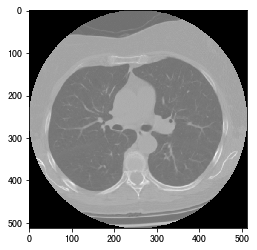

In [10]:
pixel_bytes = ds.PixelData # 原始二进制文件
pix = ds.pixel_array       # 像素值矩阵
print(pix.shape)           # 输出矩阵维度

# cmap 表示 colormap,
# 可以是设置成不同值获得不同显示效果,输出 dicom 图片
plt.imshow(pix, cmap=plt.cm.gray)
plt.show()                  

转换为完整切片组合的三维数组。

In [11]:
# 用 lstFilesDCM 作为存放 DICOM files 的列表
lstFilesDCM = []

# 将所有 DICOM 文件读入
for diName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".dcm" in filename.lower():  # 判断文件是否为 dicom 文件
            # print(filename)
            lstFilesDCM.append(os.path.join(diName, filename))  # 加入到列表中
            
# 将第一张图片作为参考图
RefDs = pydicom.read_file(lstFilesDCM[0])  # 读取第一张 DICOM 图片

# 建立三维数组,分别记录长、宽、层数(也就是该患者 DICOM 样本个数)
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))
print(ConstPixelDims)

(512, 512, 216)


## 2. 加载 DICOM 影像

在上一节中，我们概要性的介绍了 Pydicom 的基本操作。从这一节开始，我们将面向深度学习模型，了解对于 DICOM 影像所需要执行的各项数据预处理工作。由于 DICOM 是医学成像中事实上的文件标准。这些文件包含大量元数据（例如：像素大小，即：每个维度像素的长度）。扫描的这种像素大小/粗糙度因扫描而异（例如：切片之间的距离可能不同），这可能会损害 CNN 方法的性能。 我们可以通过同构重采样来处理这个问题。下面是加载扫描的代码，它由多个切片组成，我们只是将其保存在 Python 列表中。其中，数据集中的每个文件夹都是一次扫描（因此是 **一名患者**，为了降低数据量，本实验我们仅采用原始数据集中的其中一位患者的切片图像演示）。其中，数据集内缺少一个元数据字段 —— $Z$ 方向上的像素大小，即：**切片厚度**。我们需要推断出这一点，并将其添加到元数据中。

<img src="./img/dicom-file-structure.png" width="60%">

In [12]:
# 在给定的文件夹路径中加载 DICOM 扫描影像
def load_dicom(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    
    # 对患者所有的 DICOM 影像进行排序
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    
    # 计算切片厚度
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - \
                                 slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - \
                                 slices[1].SliceLocation)
    
    # 添加缺失的元数据: 切片厚度    
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

$\uparrow$ 以上代码完成了扫描一个患者的目录，加载所有的切片，按切片的 $Z$ 方向排序切片，并获取切片厚度。

## 3. HU 单位转换

CT 扫描中的测量单位是 **Hounsfield 单位 (HU)**，它是放射密度的量度。CT 扫描仪经过仔细校准以准确测量这一点，以下对应数值表来自维基百科 ——

| Substance             | HU                                              |
| :---------------------| :-----------------------------------------------|
| <b>Air</b>                   | \-1000                                          |
| <b>Lung</b>                  | \-500                                           |
| <b>Fat</b>                   | \-100 to-50                                     |
| <b>Water</b>                 | 0                                               |
| <b>CSF</b>                   | 15                                              |
| <b>Kidney</b>                | 30                                              |
| <b>Blood</b>                 | +30 to +45                                      |
| <b>Muscle</b>                | +10 to +40                                      |
| <b>Grey matter</b>           | +37 to +45                                      |
| <b>White matter</b>          | +20 to +30                                      |
| <b>Liver</b>                 | +40 to +60                                      |
| <b>Soft Tissue, Contrast</b> | +100 to +300                                    |
| <b>Bone</b>                  | +700 (cancellous bone) to +3000 (cortical bone) |

但是，默认情况下，返回的值不在此单位中。让我们解决这个问题。一些扫描仪具有圆柱形扫描边界，但输出图像是方形的。超出这些范围的像素将获得固定值 `-2000`。 第一步是将这些值设置为 `0`，当前对应于：**空气**。 接下来，回到 HU 单位，通过乘以重新缩放斜率并添加截距（方便地存储在扫描的元数据中）。

In [13]:
def get_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    
    # 转换为 int16，int16 是可接受的，因为所有的数值都应该 <32k
    image = image.astype(np.int16)

    # 设置边界外的元素为 0
    # 截距通常为 -1024，因此空气约为 0
    image[image == -2000] = 0
    
    # 转换为 HU 单位
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
    
    # 乘以重新缩放斜率
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
        
        # 添加截距
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

下面，我们可以调用上面的函数，查看其中一个患者的影像。该患者 `sample_patient` 共有 **216** 张切片影像，我们抽取中间位置的切片进行输出。

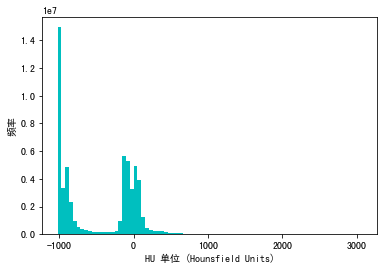

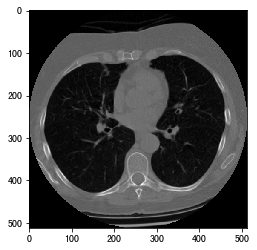

In [14]:
# 加载第一个患者的扫描片目录，由于实验数据集内只有一个患者，选择 0
sample_patient = load_dicom(dicom_folder + patients[0])
sample_patient_pixels = get_hu(sample_patient)
plt.hist(sample_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("HU 单位 (Hounsfield Units)")
plt.ylabel("频率")
plt.show()

# 其中，挑选一个中间位置的切片进行显示
plt.imshow(sample_patient_pixels[100], cmap=plt.cm.gray)
plt.show()

$\uparrow$ 查看维基百科的表格和这个直方图，我们可以清楚地看到哪些像素是空气，哪些是组织。 我们稍后将使用它来进行肺分割。

## 4. CT 重采样

CT 扫描可能的像素间距为 `[2.5, 0.5, 0.5]`，代表着切片间的距离是 `2.5` 毫米。对于不同的扫描，切片距离可能不同，譬如：`[1.5, 0.725, 0.725]`。因此，如果对于自动分析模型，如：使用 CNN 可能是一个挑战。常用的方法是将整个数据集重新采样为相同分辨率的切片。例如：将所有切片采样为 `[1 1 1]` 毫米的间距。这样就可以使用 3D 网格，而无需担心切片厚度的不确定性。

In [15]:
def resample(image, scan, new_spacing=[1,1,1]):
    # 确定当前像素间距
    spacing = np.array([scan[0].SliceThickness] + list(scan[0].PixelSpacing), 
                       dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    # 使用 scipy.ndimage.interpolation.zoom 进行数组缩放
    image = scipy.ndimage.interpolation.zoom(image, 
                                             real_resize_factor, 
                                             mode='nearest') # 插值模式
    
    return image, new_spacing

$\uparrow$ 上面的代码将患者的数字影像像素重新取样到 `1×1×1` 毫米的同构分辨率，其中新的间距采用了四舍五入，这可能与所需的间距略有出入。

In [16]:
pix_resampled, spacing = resample(sample_patient_pixels, sample_patient, [1,1,1])
print("重采样前的形状\t", sample_patient_pixels.shape)
print("重采样后的形状\t", pix_resampled.shape)

重采样前的形状	 (216, 512, 512)
重采样后的形状	 (270, 290, 290)


## 5. 渲染三维扫描影像

对于可视化来说，能够显示扫描的 3D 图像是很有用的。我们使用移动立方体为我们的 3D 对象创建一个近似的网格，并使用 matplotlib 绘制。

In [17]:
def plot_3d(image, threshold=-300):
    
    # 垂直放置扫描，
    # 因此，患者的头部会在上方，面对着摄像机
    p = image.transpose(2,1,0)
    
    verts, faces = measure.marching_cubes_classic(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # 使用`verts[faces]` 生成三角形集合
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

绘图函数采用的阈值可以被用来绘制某些结构，例如：所有组织或仅骨骼。`400` 是仅显示骨骼的阈值（可以参见上面的 Hounsfield 单位表）。

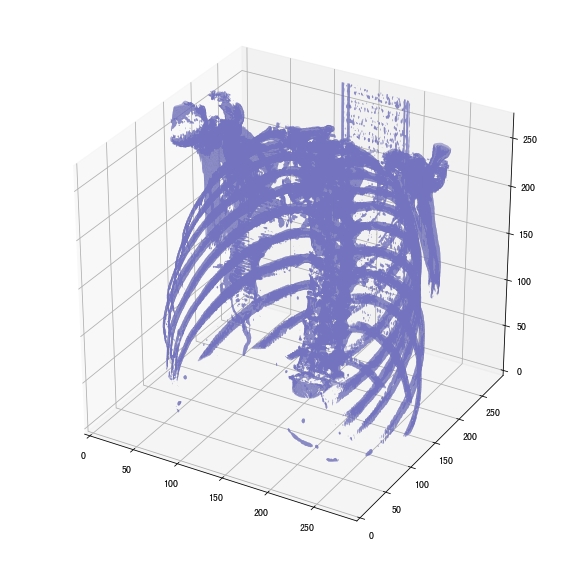

渲染总耗时： 158.1495771408081 秒


In [18]:
import time # 记录3D渲染时间
start_sum = time.time() # 记录3D渲染开始时间

# 定义 HU 阈值，仅将骨骼结构渲染为三维图像
plot_3d(pix_resampled, 400)

end_sum = time.time() # 记录3D渲染结束时间
print('渲染总耗时：',end_sum - start_sum, '秒')

## 6. 肺部切割

为了降低问题的复杂度，我们先对肺部进行切割。它涉及很多步骤：由区域生长和形态学的一系列操作组成，我们将仅使用连通分量分析 ——

- 图像阈值（`-320` HU 是一个很好的阈值）
- 连接组件，确定人体周围空气的标签，在二进制图像中用 `1` 来填充
- 可选：对于扫描中的每个轴向切片，确定最大的实心连接部件（人体身体 + 周围的空气），并将其他组件设置为 `0`。这就填满了掩码内肺部的结构
- 只保留最大的气穴 (人体到处都有其他气穴)

In [19]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    
    # 不是二进制，而是1和2。
    # 0 被视为背景，这是我们不需要的
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # 选择最角落的像素来确定哪个标签是空气
    # 优化:从患者周围选取多个背景标签
    background_label = labels[0,0,0]
    
    # 填充人体周边空气
    binary_image[background_label == labels] = 2
    
    
    # 填充肺部结构的方法 (比形态闭合之类的方法要好)
    if fill_lung_structures:
        
        # 对于每个切片，我们确定最大的固体结构
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: # 这个切片包含一些肺部组织
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 # 使图像实际二进制
    binary_image = 1-binary_image # 反过来，肺现在是 1
    
    # 去除阀体内的其他空气
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # 如果有气穴
        binary_image[labels != l_max] = 0
 
    return binary_image

In [20]:
segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)

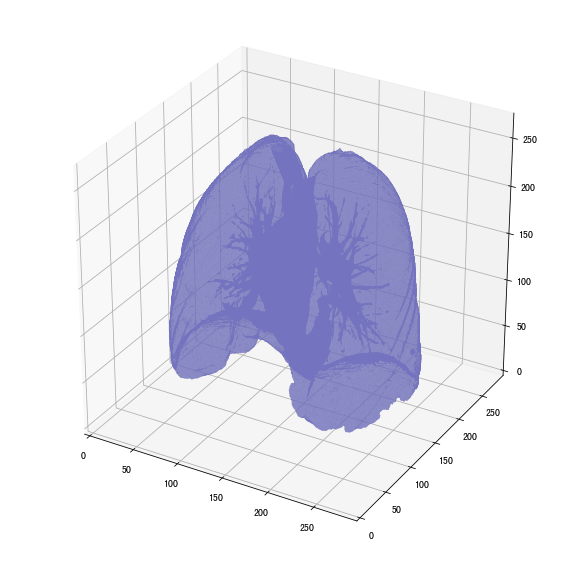

渲染总耗时： 70.52281594276428 秒


In [21]:
import time # 记录3D渲染时间
start_sum = time.time() # 记录3D渲染开始时间

plot_3d(segmented_lungs, 0)

end_sum = time.time() # 记录3D渲染结束时间
print('渲染总耗时：',end_sum - start_sum, '秒')

$\uparrow$ 看起来不错，但是我们可以进一步，在肺内包含结构（因为结节是固体），我们不希望在肺部只有空气。

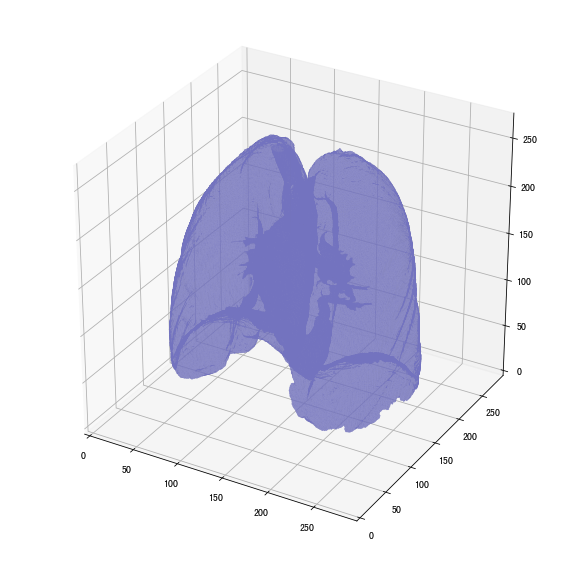

In [22]:
plot_3d(segmented_lungs_fill, 0)

我们还可以看出两者之间的差异。

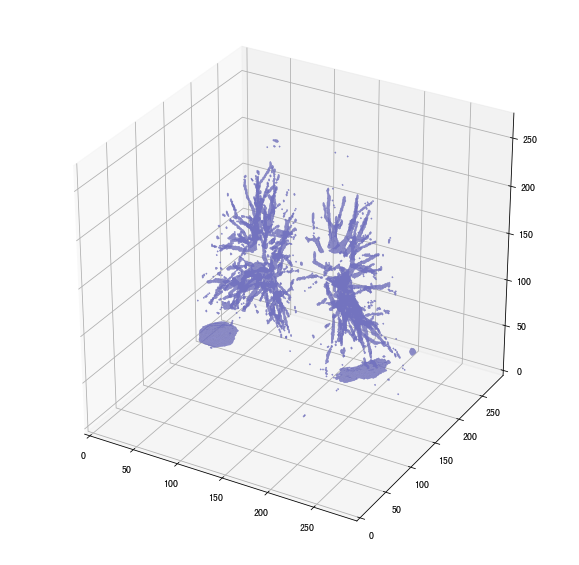

In [23]:
plot_3d(segmented_lungs_fill - segmented_lungs, 0)

当你想要使用这个蒙版时，**记得先在它上面应用一个扩张形态学操作** (比如：用一个圆形的内核)。这样可以将遮罩向各个方向扩展。仅肺内的空气+结构不会包含所有的结节，特别是那些粘在肺一侧的结节，它们经常出现，所以要稍微扩大蒙版。

**对于某些边缘情况，这种分割可能会失败**。它依赖于这样一个事实，即：患者外部的空气与肺部的空气没有连接。如果患者有 [气管切开术](https://en.wikipedia.org/wiki/Tracheotomy)，则不会出现这种情况，数据集中其它样本可能存在这种情况。此外，对于特殊的噪声图像 (例如：下图中的心脏起搏器)，这种方法也可能失败。相反，机身中第二大气囊将被分割。你可以通过检查掩模对应的图像的分数来识别这一点，在这种情况下，这个分数会非常小。然后，你可以首先应用一个几个毫米大小的内核的形态学关闭操作来关闭这些孔，之后它应该工作 (或者更简单地说，不要使用此图像的掩模)。

<img src="./img/po0eX1L.png">

## 7. 归一化

目前所有的数值在 `-1024` 到 `2000` 左右。超过 `400` 的元素其实是不需要考虑的，因为只是一些具有不同辐射密度的骨骼。常用的阈值集合在 `-1000` 到 `400` 之间。归一化处理代码如下 ——

In [24]:
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
    
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

你可以在实际数据集上调用以上函数执行图像数值归一化。

## 8. 数值中心化

作为最后的预处理步骤，建议将数据居中置零 (Zero Centering)，以便平均值为 `0`，使其接近正态分布。均值减法或对零中心化是一种常见的预处理技术，它涉及到从每个数据点减去均值使其以零为中心。假设一个神经元的输入都是正的或负的。在这种情况下，在反向传播期间计算的梯度将是正的或负的 (与输入相同的符号)。因此，参数更新只局限于特定的方向，这反过来会使其难以收敛。因此，梯度更新在不同的方向上走得太远，使得优化更加困难。当数据集是对称的 (零均值) 时，许多算法显示出更好的性能。为此，只需从所有像素中减去平均像素值。要确定这一平均值，只需平均整个数据集中的所有图像。根据在 LUNA16 竞赛中的经验，这个数字大约是 **0.25**。

**需要注意：不要将每个图像的中心置零。CT 扫描仪经过校准以返回精确的 HU 测量值。不存在像普通图片那样对比度或亮度较低的图像。**

In [25]:
# LUNA16 竞赛经验值
PIXEL_MEAN = 0.25

def zero_center(image):
    image = image - PIXEL_MEAN
    return image

你可以在实际数据集上调用以上函数执行图像数值中心化。

## 案例小结

在本案例中，你利用 Pydicom 库实现了对 DICOM 医学数字影像的预处理。通过上面的步骤，图像已经可供 CNN 或其他机器学习方法使用。同时，Pydicom 是一个强大的 Python 医学图像数据处理库，如果你希望进一步了解更多的演示示例并进行编码练习，请参考 Pydicom 的 [官方文档](https://pydicom.github.io/pydicom/stable/auto_examples/index.html)。本教程参考文档为 GUIDO ZUIDHOF 在 Kaggle 上发布的经典医学数字影像预处理教程 [Full Preprocessing Tutorial](https://www.kaggle.com/code/gzuidhof/full-preprocessing-tutorial/notebook)，本文基于新版本的 Pydicom 库对代码与内容进行了更新修复与补充。